<a href="https://colab.research.google.com/github/andraroman12/PMP-2024/blob/main/TEMA2/ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving date_studiu_nota.csv to date_studiu_nota (11).csv


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


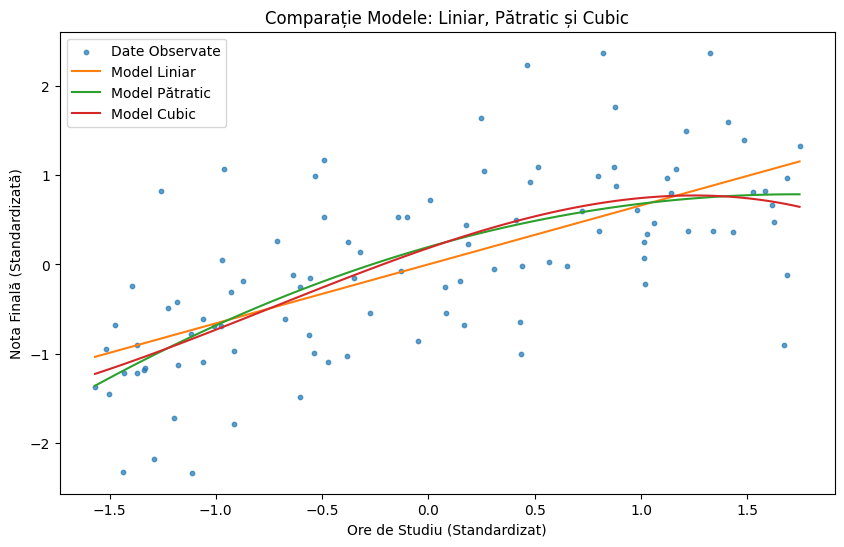


Valori WAIC:
Liniar: 233.35 (SE: 15.51)
Pătratic: 230.45 (SE: 14.78)
Cubic: 231.76 (SE: 14.50)

Valori LOO:
Liniar: 233.37 (SE: 15.52)
Pătratic: 230.49 (SE: 14.79)
Cubic: 231.83 (SE: 14.51)


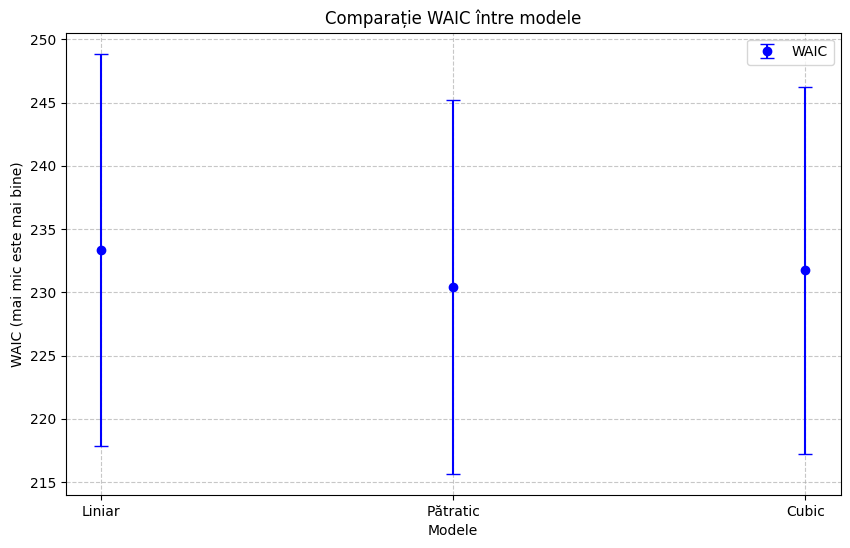

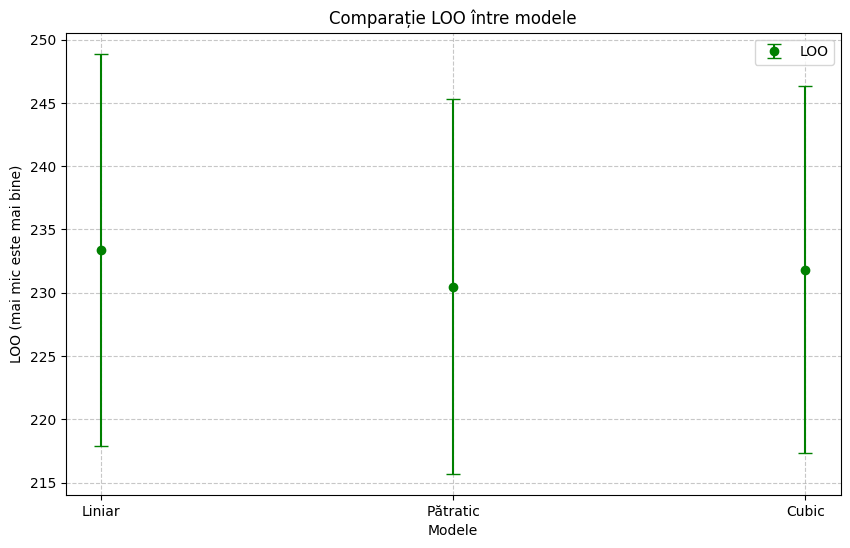

In [29]:

import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
from google.colab import files
uploaded = files.upload()
data = pd.read_csv(list(uploaded.keys())[0])

x = data['Ore_Studiu'].values
y = data['Nota_Finala'].values


x_std = (x - x.mean()) / x.std()
y_std = (y - y.mean()) / y.std()


x_poly = np.vstack([x_std**i for i in range(1, 4)])


traces = {}
waic_values = {}
loo_values = {}

#model liniar
with pm.Model() as linear_model:
    alpha = pm.Normal('Intercept', mu=0, sigma=1)
    beta = pm.Normal('Panta', mu=0, sigma=10)
    sigma = pm.HalfNormal('Eroare', sigma=1)
    mu = alpha + beta * x_poly[0]
    y_obs = pm.Normal('Observat', mu=mu, sigma=sigma, observed=y_std)
    traces['Liniar'] = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

waic_values['Liniar'] = az.waic(traces['Liniar'], scale='deviance')
loo_values['Liniar'] = az.loo(traces['Liniar'], scale='deviance')

#model patratic
with pm.Model() as quadratic_model:
    alpha = pm.Normal('Intercept', mu=0, sigma=1)
    beta = pm.Normal('Pante', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('Eroare', sigma=1)
    mu = alpha + pm.math.dot(beta, x_poly[:2])
    y_obs = pm.Normal('Observat', mu=mu, sigma=sigma, observed=y_std)
    traces['Pătratic'] = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

waic_values['Pătratic'] = az.waic(traces['Pătratic'], scale='deviance')
loo_values['Pătratic'] = az.loo(traces['Pătratic'], scale='deviance')

#model cubic
with pm.Model() as cubic_model:
    alpha = pm.Normal('Intercept', mu=0, sigma=1)
    beta = pm.Normal('Pante', mu=0, sigma=10, shape=3)
    sigma = pm.HalfNormal('Eroare', sigma=1)
    mu = alpha + pm.math.dot(beta, x_poly[:3])
    y_obs = pm.Normal('Observat', mu=mu, sigma=sigma, observed=y_std)
    traces['Cubic'] = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)

waic_values['Cubic'] = az.waic(traces['Cubic'], scale='deviance')
loo_values['Cubic'] = az.loo(traces['Cubic'], scale='deviance')

x_new = np.linspace(x_std.min(), x_std.max(), 100)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x_std, y_std, c='C0', s=10, alpha=0.7, label='Date Observate')

#model liniar
alpha_l = traces['Liniar'].posterior['Intercept'].mean(('chain', 'draw')).values
beta_l = traces['Liniar'].posterior['Panta'].mean(('chain', 'draw')).values
y_l = alpha_l + beta_l * x_new
ax.plot(x_new, y_l, label="Model Liniar", color='C1')

#model patratic
alpha_p = traces['Pătratic'].posterior['Intercept'].mean(('chain', 'draw')).values
beta_p = traces['Pătratic'].posterior['Pante'].mean(('chain', 'draw')).values
y_p = alpha_p + beta_p[0] * x_new + beta_p[1] * x_new**2
ax.plot(x_new, y_p, label="Model Pătratic", color='C2')

#model cubic
alpha_c = traces['Cubic'].posterior['Intercept'].mean(('chain', 'draw')).values
beta_c = traces['Cubic'].posterior['Pante'].mean(('chain', 'draw')).values
y_c = alpha_c + beta_c[0] * x_new + beta_c[1] * x_new**2 + beta_c[2] * x_new**3
ax.plot(x_new, y_c, label="Model Cubic", color='C3')


ax.set_xlabel("Ore de Studiu (Standardizat)")
ax.set_ylabel("Nota Finală (Standardizată)")
ax.set_title("Comparație Modele: Liniar, Pătratic și Cubic")
ax.legend()
plt.show()


print("\nValori WAIC:")
for model, waic in waic_values.items():
    print(f"{model}: {waic.waic:.2f} (SE: {waic.waic_se:.2f})")

print("\nValori LOO:")
for model, loo in loo_values.items():
    print(f"{model}: {loo.loo:.2f} (SE: {loo.loo_se:.2f})")

#grafic pt WAIC
waic_estimates = [waic_values[model].waic for model in waic_values]
waic_erori = [waic_values[model].waic_se for model in waic_values]
modele = list(waic_values.keys())

plt.figure(figsize=(10, 6))
plt.errorbar(modele, waic_estimates, yerr=waic_erori, fmt='o', capsize=5, label='WAIC', color='blue')
plt.title("Comparație WAIC între modele")
plt.ylabel("WAIC ")
plt.xlabel("Modele")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

#grafic  LOO
loo_estimates = [loo_values[model].loo for model in loo_values]
loo_erori = [loo_values[model].loo_se for model in loo_values]

plt.figure(figsize=(10, 6))
plt.errorbar(modele, loo_estimates, yerr=loo_erori, fmt='o', capsize=5, label='LOO', color='green')
plt.title("Comparație LOO între modele")
plt.ylabel("LOO (mai mic este mai bine)")
plt.xlabel("Modele")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()
